# Preprocessing

In [160]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
%autoreload 2

In [162]:
import torch

In [163]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel
import json


In [164]:
connection = Connection()
# Get client
client = connection.get_client()

In [165]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [166]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [167]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
W06 Record count before target preprocessing: 100
W06 Record count after target preprocessing: 100
W06 Record count after preprocessing: 100
W08 original record count: 69
W08 Record count before target preprocessing: 66
W08 Record count after target preprocessing: 66
W08 Record count after preprocessing: 66
W10 original record count: 222
W10 Record count before target preprocessing: 221
W10 Record count after target preprocessing: 221
W10 Record count after preprocessing: 221
W11 original record count: 154
W11 Record count before target preprocessing: 119
W11 Record count after target preprocessing: 119
W11 Record count after preprocessing: 119
W15 original record count: 86
W15 Record count before target preprocessing: 86
W15 Record count after target preprocessing: 86
W15 Record count after preprocessing: 86
W18 original record count: 89
W18 Record count before target preprocessing: 86
W18 Record count after target preproc

755

In [168]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          30
qg_mpfm          30
qw_mpfm          30
wc_mpfm           0
gor_mpfm         35
wgr_mpfm         36
gor_well_test     0
wgr_well_test     0
well_id           0
time_idx          0
dtype: int64

In [192]:
df_train, df_val, df_test = get_blocked_temporal_train_val_test_split(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

W06: n_blocks=49
W08: n_blocks=49
W10: n_blocks=49
W11: n_blocks=49
W15: n_blocks=49
W18: n_blocks=49
W19: n_blocks=49
Train=575, Validation=50, Test=130


In [193]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [194]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry,)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.7130


In [195]:
physics_scores = model.score_physics(df_train)
physics_scores

{'W06': {'qo': {'r2': 0.6476496443091442,
   'mae': 15.889930175380226,
   'rmse': 21.026378962649243,
   'mape (%)': 18.973241964174868,
   'mpe (%)': 9.508573795126383},
  'qw': {'r2': 0.051256071837308625,
   'mae': 1.0122387393582093,
   'rmse': 1.1850438412910456,
   'mape (%)': 13704.410743205957,
   'mpe (%)': 13666.393215452857},
  'qg': {'r2': 0.6830756639076023,
   'mae': 2228.3999036022838,
   'rmse': 2836.208775090469,
   'mape (%)': 773.0371091694386,
   'mpe (%)': 747.3666161972154},
  'wgr': {'r2': -2.1525610756138196,
   'mae': 8.785670973691742e-05,
   'rmse': 0.00014041464915421424,
   'mape (%)': 731.5436669656937,
   'mpe (%)': 691.93643033578},
  'gor': {'r2': -1.3627201284849781,
   'mae': 18.412778298341895,
   'rmse': 31.859445770486342,
   'mape (%)': 473.43752296661876,
   'mpe (%)': 447.7638436053259}},
 'W08': {'qo': {'r2': -0.60694131416494,
   'mae': 12.22575903449465,
   'rmse': 16.476465981640544,
   'mape (%)': 50.70305980354875,
   'mpe (%)': -22.49585

In [196]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.9535584725443996,
   'mae': 6.998014133804053,
   'rmse': 7.794191363308389,
   'mape (%)': 7.008242391031638,
   'mpe (%)': 4.4966717028494685},
  'qw': {'r2': -1.9879096878002942,
   'mae': 2.044165028244518,
   'rmse': 2.5061171135182585,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.9334197257605875,
   'mae': 940.4819868633751,
   'rmse': 1147.3080991626134,
   'mape (%)': 8.22464074679325,
   'mpe (%)': -1.3609532691285526},
  'wgr': {'r2': -2.1768382230561665,
   'mae': 0.0001443706744691274,
   'rmse': 0.00017440681769172764,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -87.79690306981028,
   'mae': 14.788932890170699,
   'rmse': 21.232799401355646,
   'mape (%)': 12.022460043625246,
   'mpe (%)': -4.751829029332845}},
 'W08': {'qo': {'r2': -1.8090153371383906,
   'mae': 17.281836432654508,
   'rmse': 19.084445735721552,
   'mape (%)': 112.18313691335075,
   'mpe (%)': 100.60604088333696},
  'qw': {'r2': -0.484594787552262

In [197]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.995861545668725,
   'mae': 1.8366659309826818,
   'rmse': 2.3266813052397746,
   'mape (%)': 1.351338853124548,
   'mpe (%)': 1.0910576949938566},
  'qw': {'r2': -0.9481405773066476,
   'mae': 1.570935425607773,
   'rmse': 2.0236144648442536,
   'mape (%)': 1105.944087668066,
   'mpe (%)': 980.8981931015293},
  'qg': {'r2': 0.9923397949594829,
   'mae': 358.89695295203177,
   'rmse': 389.1593477675712,
   'mape (%)': 2.374256122384397,
   'mpe (%)': 2.374256122384397},
  'wgr': {'r2': -1.0424943025897524,
   'mae': 0.00011070115813009436,
   'rmse': 0.00013984480412941906,
   'mape (%)': 66.48167535542804,
   'mpe (%)': -66.48167535542804},
  'gor': {'r2': 0.2969799028313357,
   'mae': 1.5731798012702072,
   'rmse': 1.8892621210666718,
   'mape (%)': 1.2847373076640392,
   'mpe (%)': 1.2785176751245433}},
 'W08': {'qo': {'r2': 0.7908670548700876,
   'mae': 4.26333855300117,
   'rmse': 5.20731347911269,
   'mape (%)': 26.49499391070273,
   'mpe (%)': 4.8618322337

In [198]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

In [199]:
p = model.phys_models["W19"].params_
print(p["C_gl"])


8.2034040676780755e-25


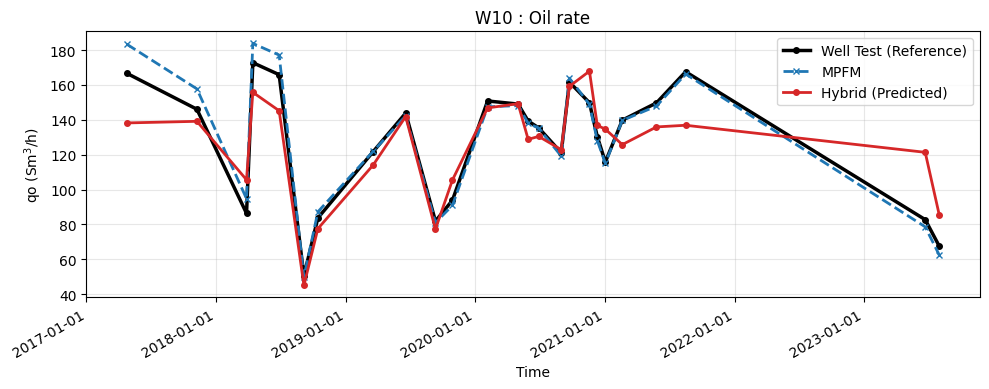

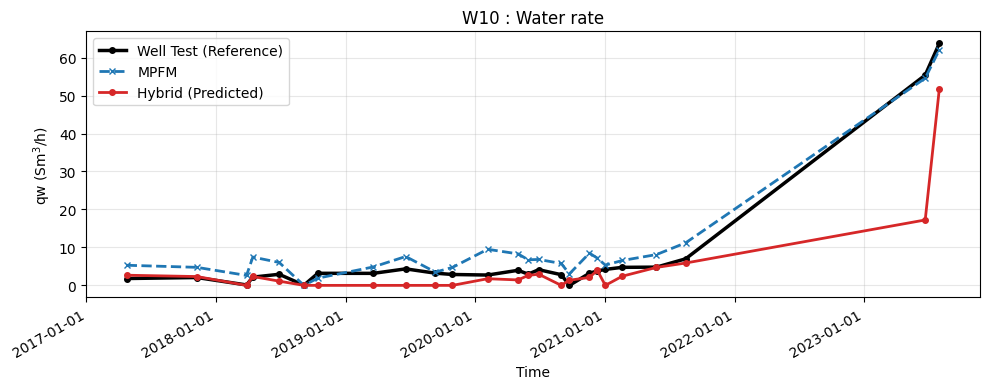

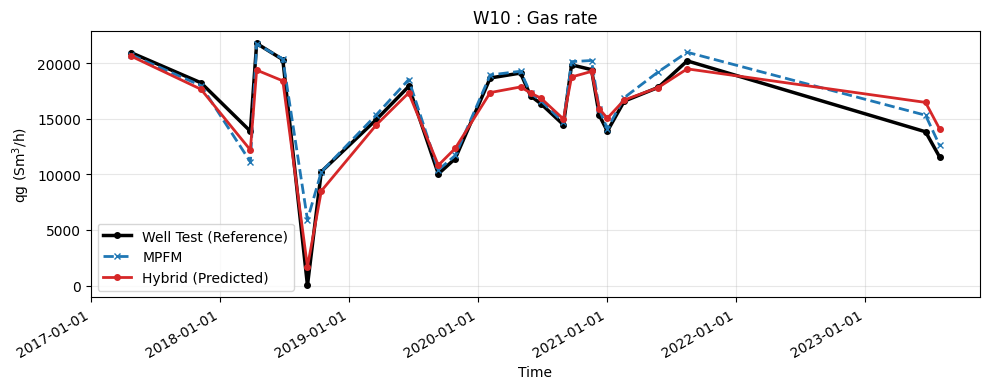

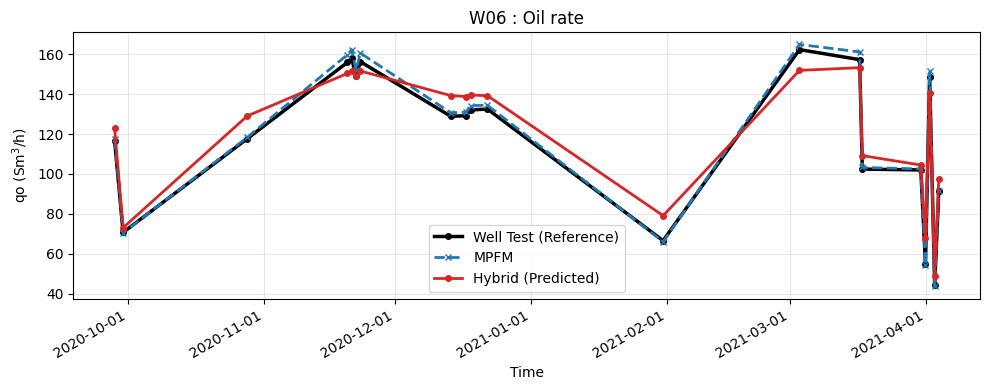

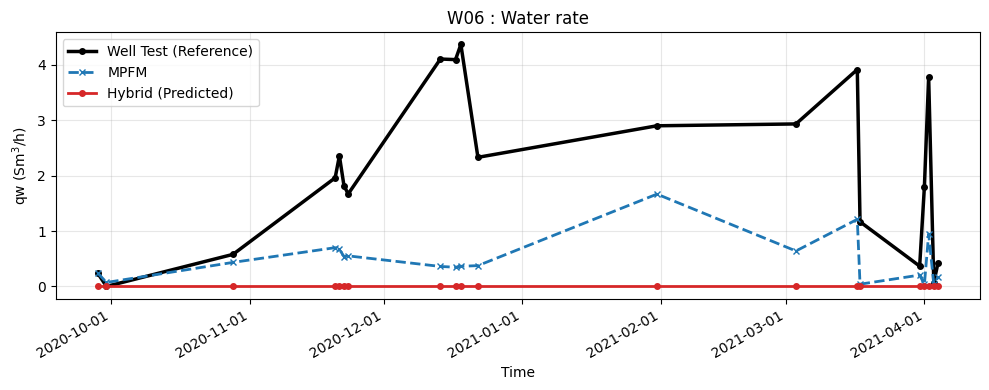

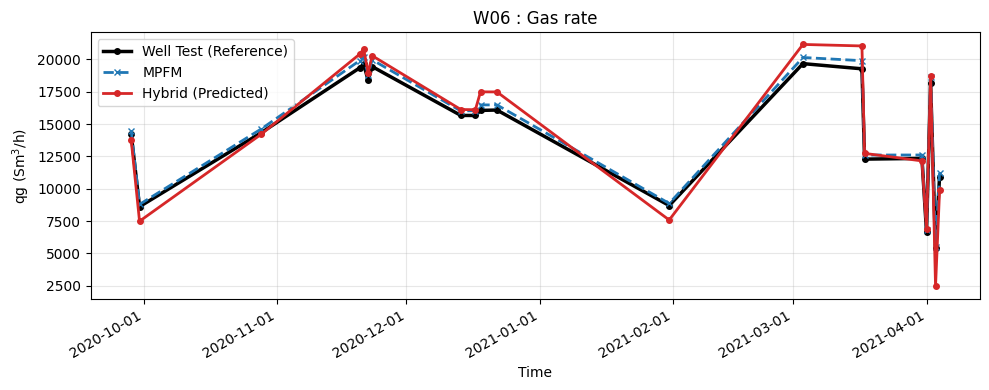

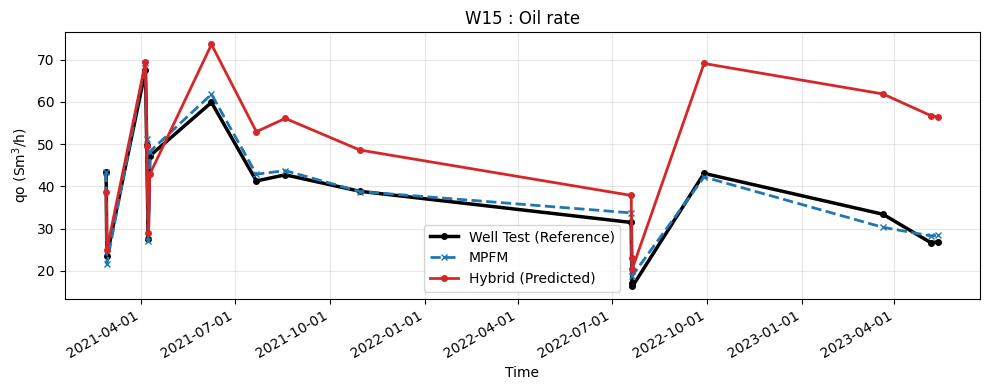

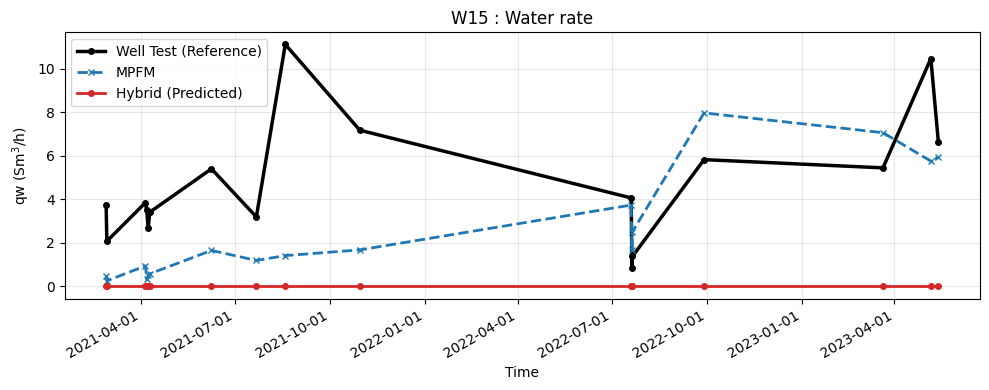

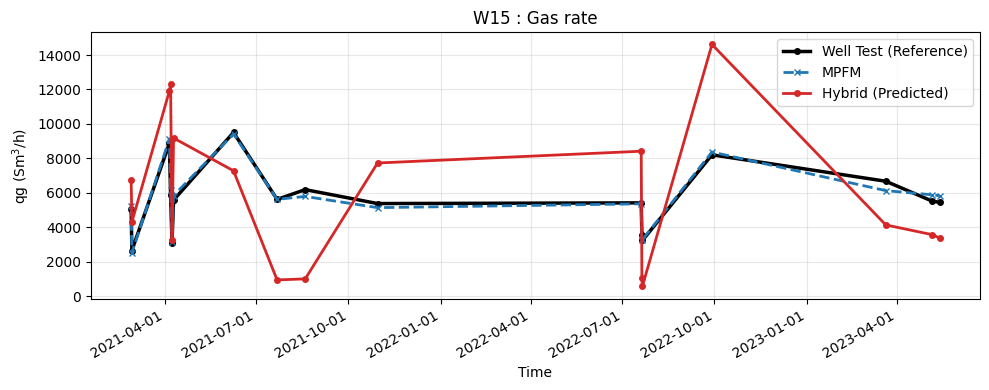

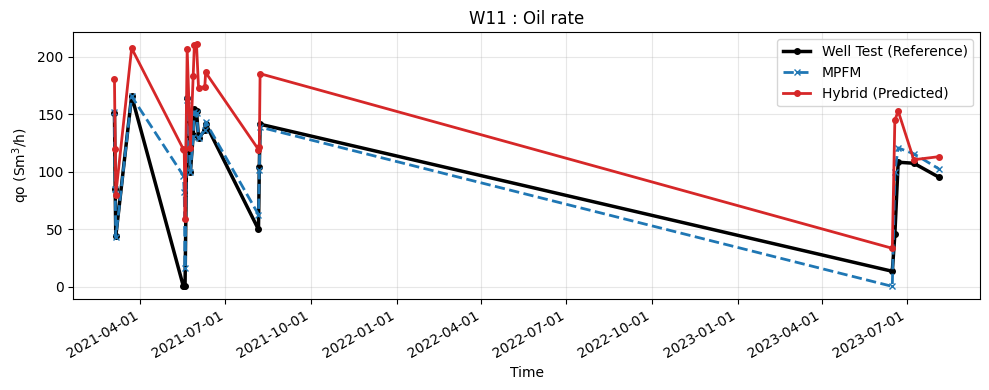

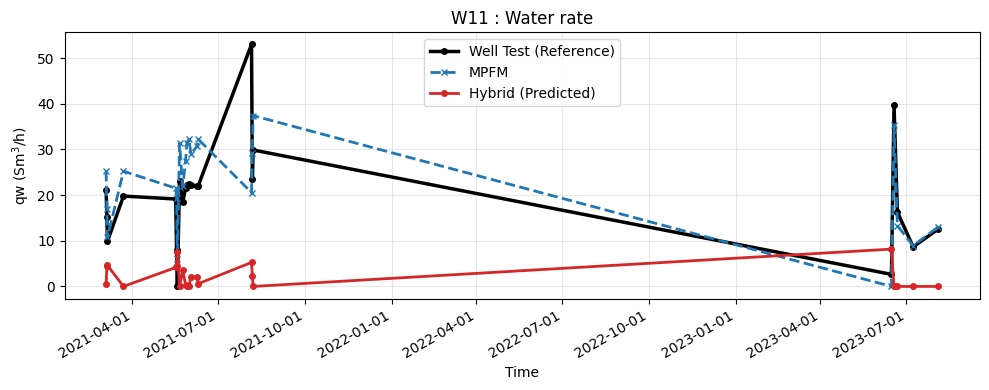

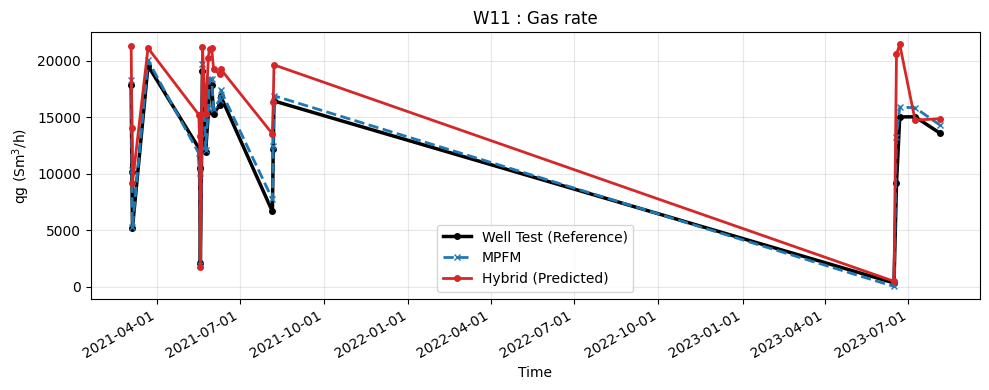

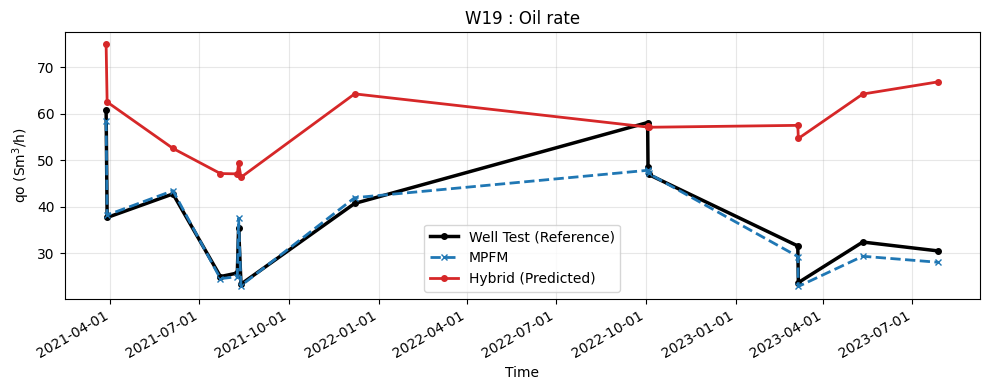

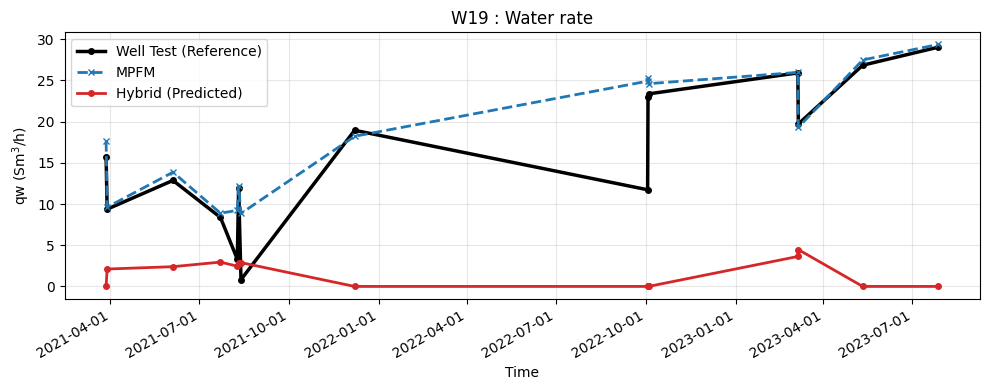

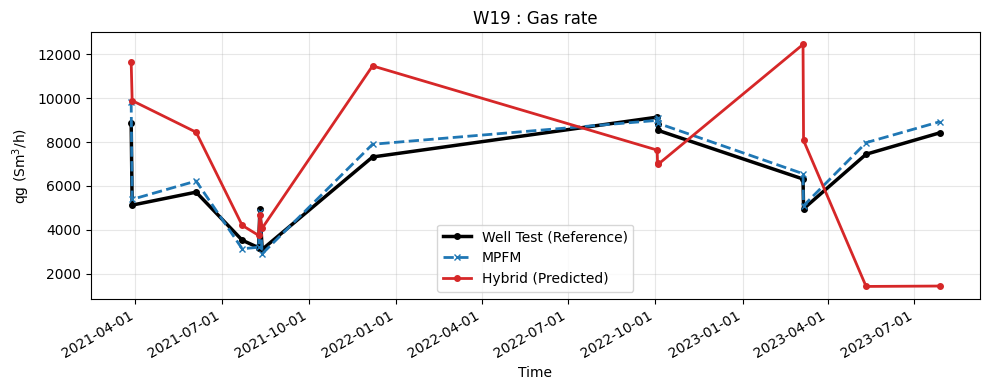

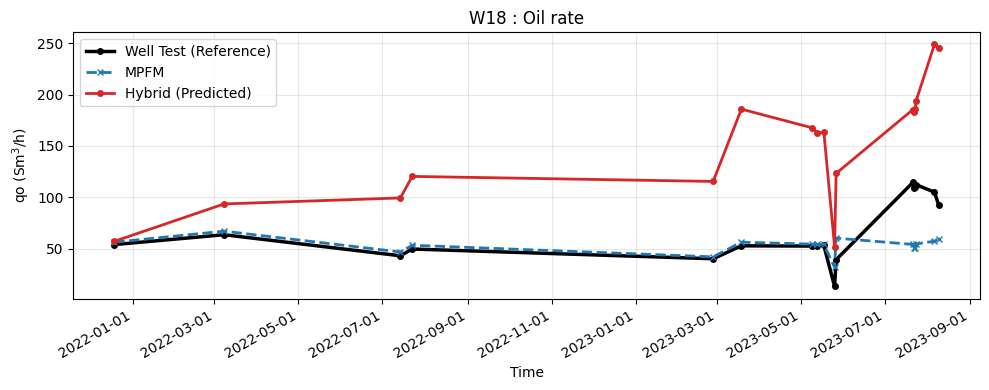

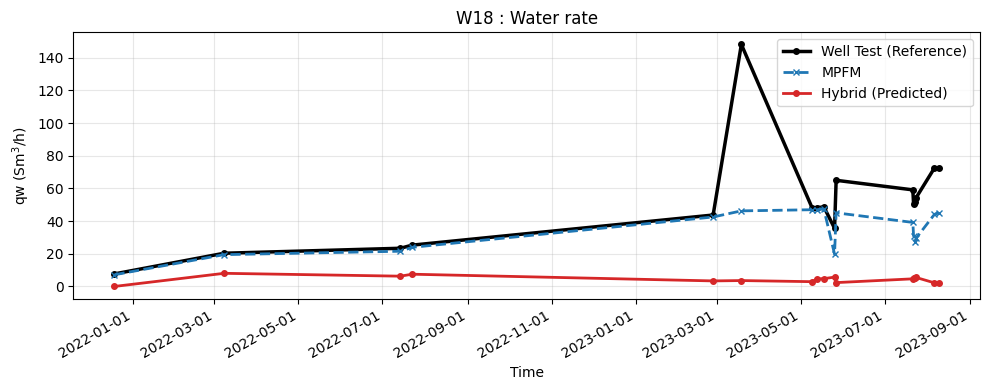

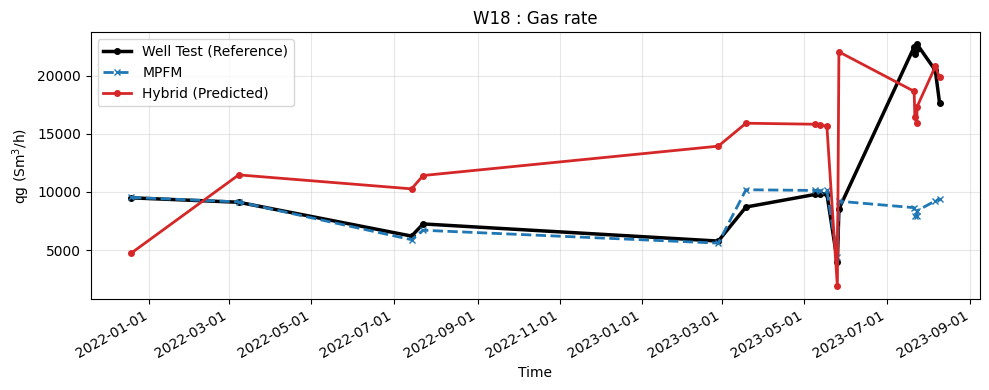

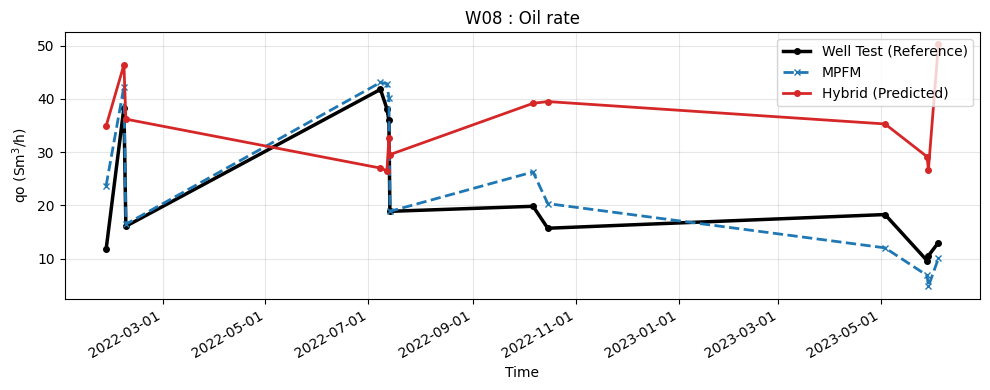

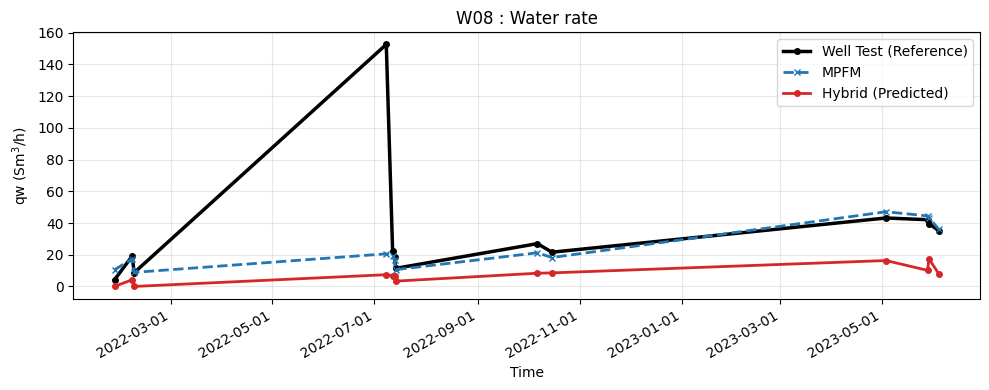

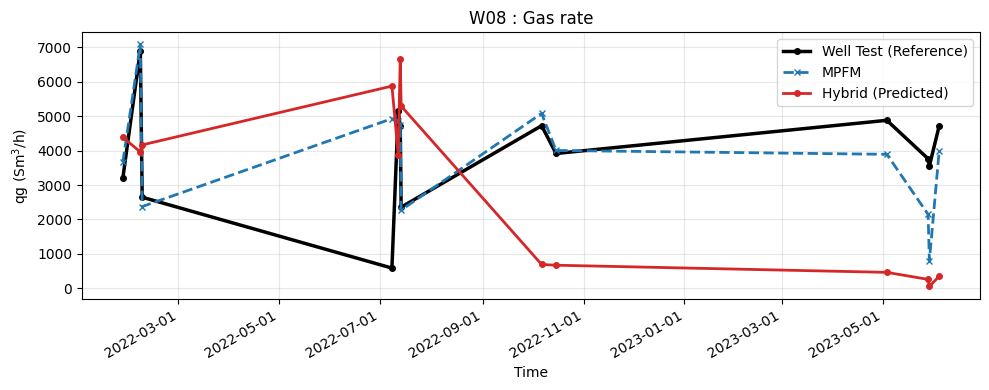

In [200]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [201]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
print(f"{len(df_train_lowo)}, {len(df_val_lowo)}, {len(df_calibration_lowo)}, {len(df_test_lowo)}")

W10: n_blocks=76
428, 106, 23, 198


In [202]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=None)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[Validation] Residual RMSE = 0.6629


In [203]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)

In [204]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': -0.27271999607678454,
   'mae': 26.912584902568092,
   'rmse': 35.27712834077476,
   'mape (%)': 33.3531707650407,
   'mpe (%)': 31.1046186375092},
  'qw': {'r2': -0.027366428601856674,
   'mae': 3.970383388381097,
   'rmse': 10.791889842135586,
   'mape (%)': 199250.255023519,
   'mpe (%)': 199141.7773832885},
  'qg': {'r2': 0.7446828150337665,
   'mae': 1444.2008627147388,
   'rmse': 1993.4504431212936,
   'mape (%)': 256.69703574335114,
   'mpe (%)': 249.8821511547229},
  'wgr': {'r2': -0.07558498323374185,
   'mae': 0.000332941361800225,
   'rmse': 0.0009796156904183625,
   'mape (%)': 81.97733073397427,
   'mpe (%)': -32.68195276666886},
  'gor': {'r2': -2.5793137034560565,
   'mae': 19.104868825839624,
   'rmse': 30.303645670621684,
   'mape (%)': 121.27447434208266,
   'mpe (%)': 92.39023959417385}}}

In [205]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.03849295229321048,
   'mae': 26.421939646450504,
   'rmse': 30.6621798929126,
   'mape (%)': 23.0372530393595,
   'mpe (%)': 14.61206685720259},
  'qw': {'r2': -0.0367572690494844,
   'mae': 4.849727457151607,
   'rmse': 10.841100315920002,
   'mape (%)': 98.54141475236254,
   'mpe (%)': -98.54141475236254},
  'qg': {'r2': -0.41034470509160803,
   'mae': 4403.644864482259,
   'rmse': 4685.199153255175,
   'mape (%)': 61.188604012015034,
   'mpe (%)': 12.434209346384389},
  'wgr': {'r2': -0.07750776012865757,
   'mae': 0.0004016126526691681,
   'rmse': 0.0009804909078101078,
   'mape (%)': 98.68485408204405,
   'mpe (%)': -98.68485408204405},
  'gor': {'r2': -7.534330739465791,
   'mae': 36.28919976659604,
   'rmse': 46.79287532336008,
   'mape (%)': 53.23985675688544,
   'mpe (%)': -1.285983378962734}}}

In [206]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9697242022304116,
   'mae': 3.064387711691724,
   'rmse': 5.47751640691784,
   'mape (%)': 2.799322118550388,
   'mpe (%)': 0.2842139543963093},
  'qw': {'r2': 0.926711324899286,
   'mae': 2.4565395200254776,
   'rmse': 2.908994607821634,
   'mape (%)': 573370.9049371746,
   'mpe (%)': 573357.1283339787},
  'qg': {'r2': 0.930602296563295,
   'mae': 547.7318442532036,
   'rmse': 1046.420426094552,
   'mape (%)': 444.22768028743417,
   'mpe (%)': 443.52890932684613},
  'wgr': {'r2': 0.9490530988524549,
   'mae': 0.00016991937411625993,
   'rmse': 0.0002153374311233594,
   'mape (%)': 135.62877355053303,
   'mpe (%)': 121.86732948163632},
  'gor': {'r2': 0.15765078695637957,
   'mae': 7.506649835792343,
   'rmse': 14.851340425509605,
   'mape (%)': 451.1880489393518,
   'mpe (%)': 448.7903262143802}}}

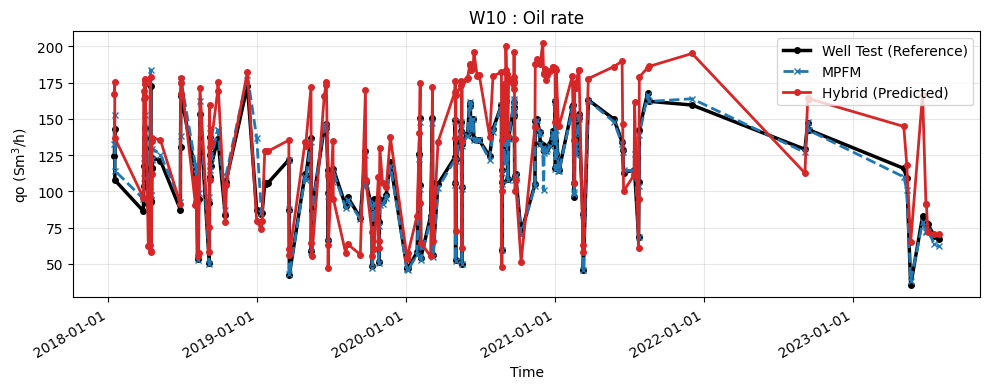

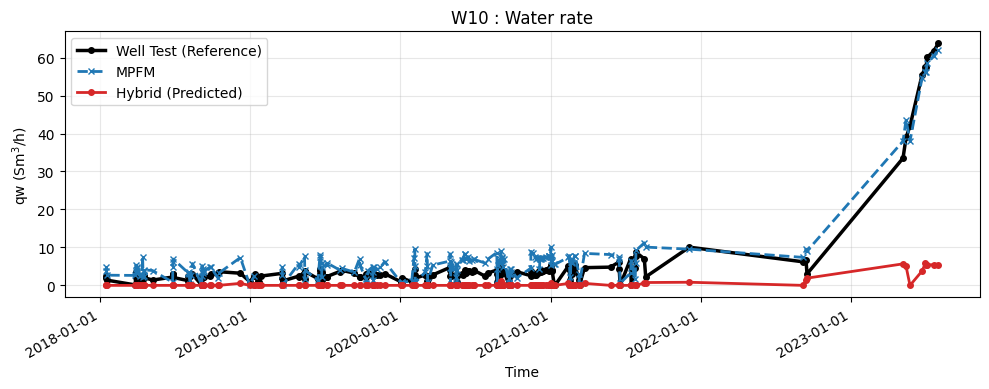

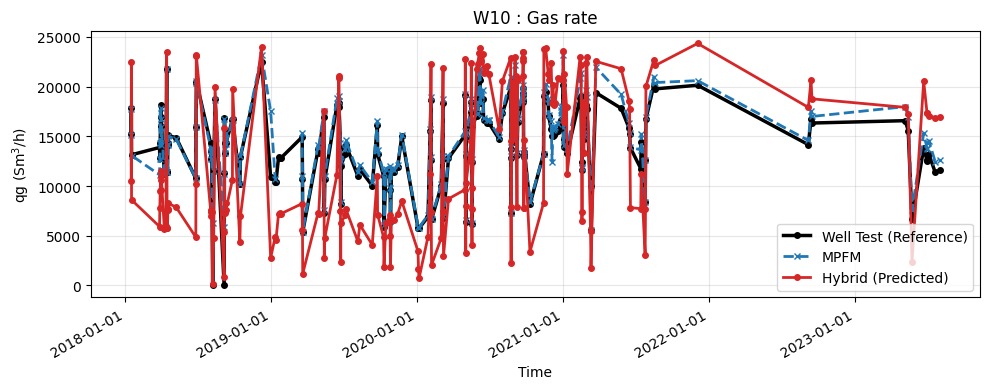

In [207]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [208]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [209]:
# df_resampled.index

In [210]:
# df_resampled.columns

In [211]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [212]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [213]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [214]:
# summarize_null(df_generated)